In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from datetime import datetime
import os
import random



# from package import batch_gd, new_labels, report, convert_labels
from util import vcpi_util

----
# Global Variables


In [59]:
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
BATCH_SIZE = 128
LATENT_SPACE_DIM = 2

MODEL_PATH = 'model_result'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Sample and Explore

We will be using the dataset provided of the GTSRB (German Traffic Sign Recognition Benchmark) to train a model to recognize traffic signs. The dataset consists of 43 classes of traffic signs and is already split into training and testing sets.

-  We defined the standard size of the images to be 32 by 32 which is the size of the smaller images in the dataset and since we have very low computational power we decided to keep the size of the images small.

In [60]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize([32, 32]), # Resize images to 32x32
    transforms.ToTensor() # Convert images to torch Tensors and rescale pixels to [0, 1]
])

# Import datasets from the directory
train_dataset = datasets.ImageFolder(root='./train_images', transform=transform)
test_dataset = datasets.ImageFolder(root='./test_images', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Length of the train and test datasets
print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

# Check the number of classes in the train and test datasets
print(f'Number of classes in training set: {len(train_dataset.classes)}')
print(f'Number of classes in test set: {len(test_dataset.classes)}')

# Verify class distribution
# print(f'Class distribution in training set: {train_dataset.class_to_idx}')
# print(f'Class distribution in test set: {test_dataset.class_to_idx}')

Training set size: 39209
Test set size: 12630
Number of classes in training set: 43
Number of classes in test set: 43


# Pre-computing Labels

In [61]:
# # Save labels to files to reduce I/O overhead during analysis
# train_labels = []
# for _, y in train_loader:
#     train_labels.extend(y.numpy())

# test_labels = []
# for _, y in test_loader:
#     test_labels.extend(y.numpy())


# np.save('cache/train_labels.npy', np.array(train_labels))
# np.save('cache/test_labels.npy', np.array(test_labels))

# Visualize some of the images in the dataset

Image shape: torch.Size([128, 3, 32, 32]), label shape: torch.Size([128])
Min and max pixel values: [0.019607843831181526, 1.0]
Number of classes 41


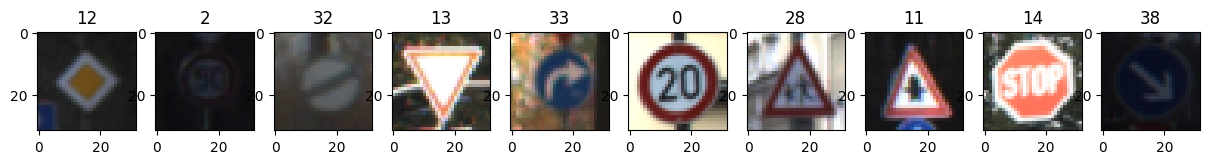

In [62]:
# Visualize random images from the training set
for x, y in train_loader:

    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')

    figure, axis = plt.subplots(1, 10, figsize=(15,15))

    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We verify that the number of classes is 43 and that the number of images in the training and testing sets is 34799 and 12630 respectively. 
- Since the number of classes is relatively large, we can try to group the classes into fewer categories to simplify the problem. 
- We can also try to use data augmentation to increase the number of images in the training set. This will help the model generalize better and prevent overfitting.
- We can also note that the images have very different brightness and contrast levels. We should try to normalize the images to make the model more robust to these variations.

# Data Preprocessing

In [63]:
def plot_distrib(data_path: str, title: str):
    # Load data from the .npy file
    data = np.load(data_path)
    
    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['Labels'])
    
    # Plot the distribution using Plotly Express
    fig = px.histogram(df, x='Labels', title=title)
    fig.show()

# Plot distribution for train labels
plot_distrib(data_path='cache/train_labels.npy', title="Training samples distribution")

# Plot distribution for test labels
plot_distrib(data_path='cache/test_labels.npy', title="Testing samples distribution")


There is a lot of imbalance between classes, for example, class 0, 19, 32 and others have very few images, close to 60, whilst others like 2 and 38 have close to 750. If this imbalance leads to poor performance, we can try some techniques to improve the data:
- Augmenting the classes with fewer images by rotating, changing colors, cropping to have more data
- Applying class weights to the loss function to penalize the model more when it makes mistakes on the classes with fewer images
- Reduce the number of classes by creating more general categories - This is not what we intend to do as it differs from our goal of recognizing the traffic signs as they are, but it is an option if the model is not performing well

# Data Augmentation and Alteration

### Split data Into Training and Validation Sets

We will divide our training dataset into training and validation sets. We will use 80% of the data for training and 20% for validation.

In [64]:
train_percentage = 0.8
total_samples = len(train_dataset)

train_size = int(train_percentage * total_samples)
val_size = total_samples - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

Training set size: 31367
Validation set size: 7842


# 1. First Model without any Data Augmentation

In [65]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=43):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.LeakyReLU(0.01)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.LeakyReLU(0.01)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(512)
        self.relu3 = nn.LeakyReLU(0.01)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        self.fc1 = nn.Linear(512*4*4, 128)
        self.relu4 = nn.LeakyReLU(0.01)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        x = x.view(-1, 512*4*4)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        
        x = self.fc2(x)
        return x

# Callbacks

In [66]:
class ModelCheckpoint:
    def __init__(self, file_path):
        self.file_path = file_path
        self.best_accuracy = 0.0

    def __call__(self, model, val_accuracy):
        if val_accuracy > self.best_accuracy:
            torch.save(model.state_dict(), self.file_path)
            self.best_accuracy = val_accuracy
            print(f"Saved model with validation accuracy: {val_accuracy:.4f} to {self.file_path}")

In [67]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping after {self.patience} epochs without improvement in validation loss.")
                return True
        return False

In [68]:
class EarlyStoppingAtAccuracy:
    def __init__(self, target_accuracy):
        self.target_accuracy = target_accuracy

    def __call__(self, val_accuracy):
        if val_accuracy >= self.target_accuracy:
            print(f"\nReached target validation accuracy ({self.target_accuracy}), stopping training!")
            return True
        return False

In [69]:
# Instantiate the model
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create ReduceLROnPlateau scheduler
reduce_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Print the summary of the model
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           9,728
       BatchNorm2d-2          [-1, 128, 28, 28]             256
         LeakyReLU-3          [-1, 128, 28, 28]               0
         Dropout2d-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 256, 24, 24]         819,456
       BatchNorm2d-6          [-1, 256, 24, 24]             512
         LeakyReLU-7          [-1, 256, 24, 24]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
         Dropout2d-9          [-1, 256, 12, 12]               0
           Conv2d-10            [-1, 512, 8, 8]       3,277,312
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
        MaxPool2d-13            [-1, 512, 4, 4]               0
        Dropout2d-14            [-1, 51

c:\Users\despacito\miniconda3\envs\vcpi\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



In [71]:
# Define the path to save the model
output_model_1_file_path = 'model/cnn_model_1.pth'

# Define the number of epochs
num_epochs = 50


# Initialize the best validation accuracy
best_val_accuracy = 0.0

# Define the Early Stopping at Accuracy callback
early_stopping_callback = EarlyStoppingAtAccuracy(target_accuracy=1.0)

# Initialize counters
total_steps = len(train_loader)
current_step = 0
print_every = 10  # Adjust printing frequency

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print training progress
        current_step += 1
        if current_step % print_every == 0 or current_step == total_steps:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{current_step}/{total_steps}], Loss: {loss.item():.4f}")
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()  # Calculate validation loss
        val_accuracy = correct / total
        val_loss /= len(val_loader)  # Average validation loss
        
    # Print validation accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), output_model_1_file_path)
        print(f"Saved model with validation accuracy: {val_accuracy:.4f} to {output_model_1_file_path}")
    
    # Check for early stopping
    if early_stopping_callback(val_accuracy):
        break
    
    # Adjust learning rate based on validation loss
    reduce_lr_scheduler.step(val_loss)


Epoch [1/50], Step [10/246], Loss: 2.3889
Epoch [1/50], Step [20/246], Loss: 1.9978
Epoch [1/50], Step [30/246], Loss: 1.9780


KeyboardInterrupt: 